In [115]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
!pip install -q torchsummary --user
from torchsummary import summary
from os import listdir
import csv

In [80]:
path = "/kaggle/input/planet-understanding-the-amazon-from-space"
os.listdir(path)

['Kaggle-planet-train-tif.torrent',
 'test_v2_file_mapping.csv',
 'train_v2.csv',
 'Kaggle-planet-test-tif.torrent',
 'sample_submission_v2.csv']

In [81]:
#Loading the image datasets
train_cv = '/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv'
test_cv = '/kaggle/input/sample-sub/sample_submission_v2.csv'
train_images = '/kaggle/input/train-image/train-jpg/train_0.jpg'
test_images = '/kaggle/input/planet-understanding-the-amazon-from-space/test-jpg'

In [82]:
train_images

'/kaggle/input/train-image/train-jpg/train_0.jpg'

In [83]:
# Load csv.
train_df = pd.read_csv(train_cv)
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [84]:
test_df=pd.read_csv(test_cv)
print(test_df.shape)
test_df.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [85]:
!pip install requests

In [87]:
import matplotlib.pyplot as plt
from matplotlib.image import imread


In [92]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /kaggle/working


In [128]:
path = "/kaggle/input/train-image"
path_train = os.path.join(path, "train-jpg")
print(
    f"train_files: {len(os.listdir(path_train))}, "
    )

train_files: 40479, 


In [116]:
path = "/kaggle/input/train-image"
path_train = os.path.join(path, "train-jpg")
pata=os.listdir(path_train)


In [134]:
train_df.head()

,image_name,tags,list_tags
0,train_0,haze primary,"[haze, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


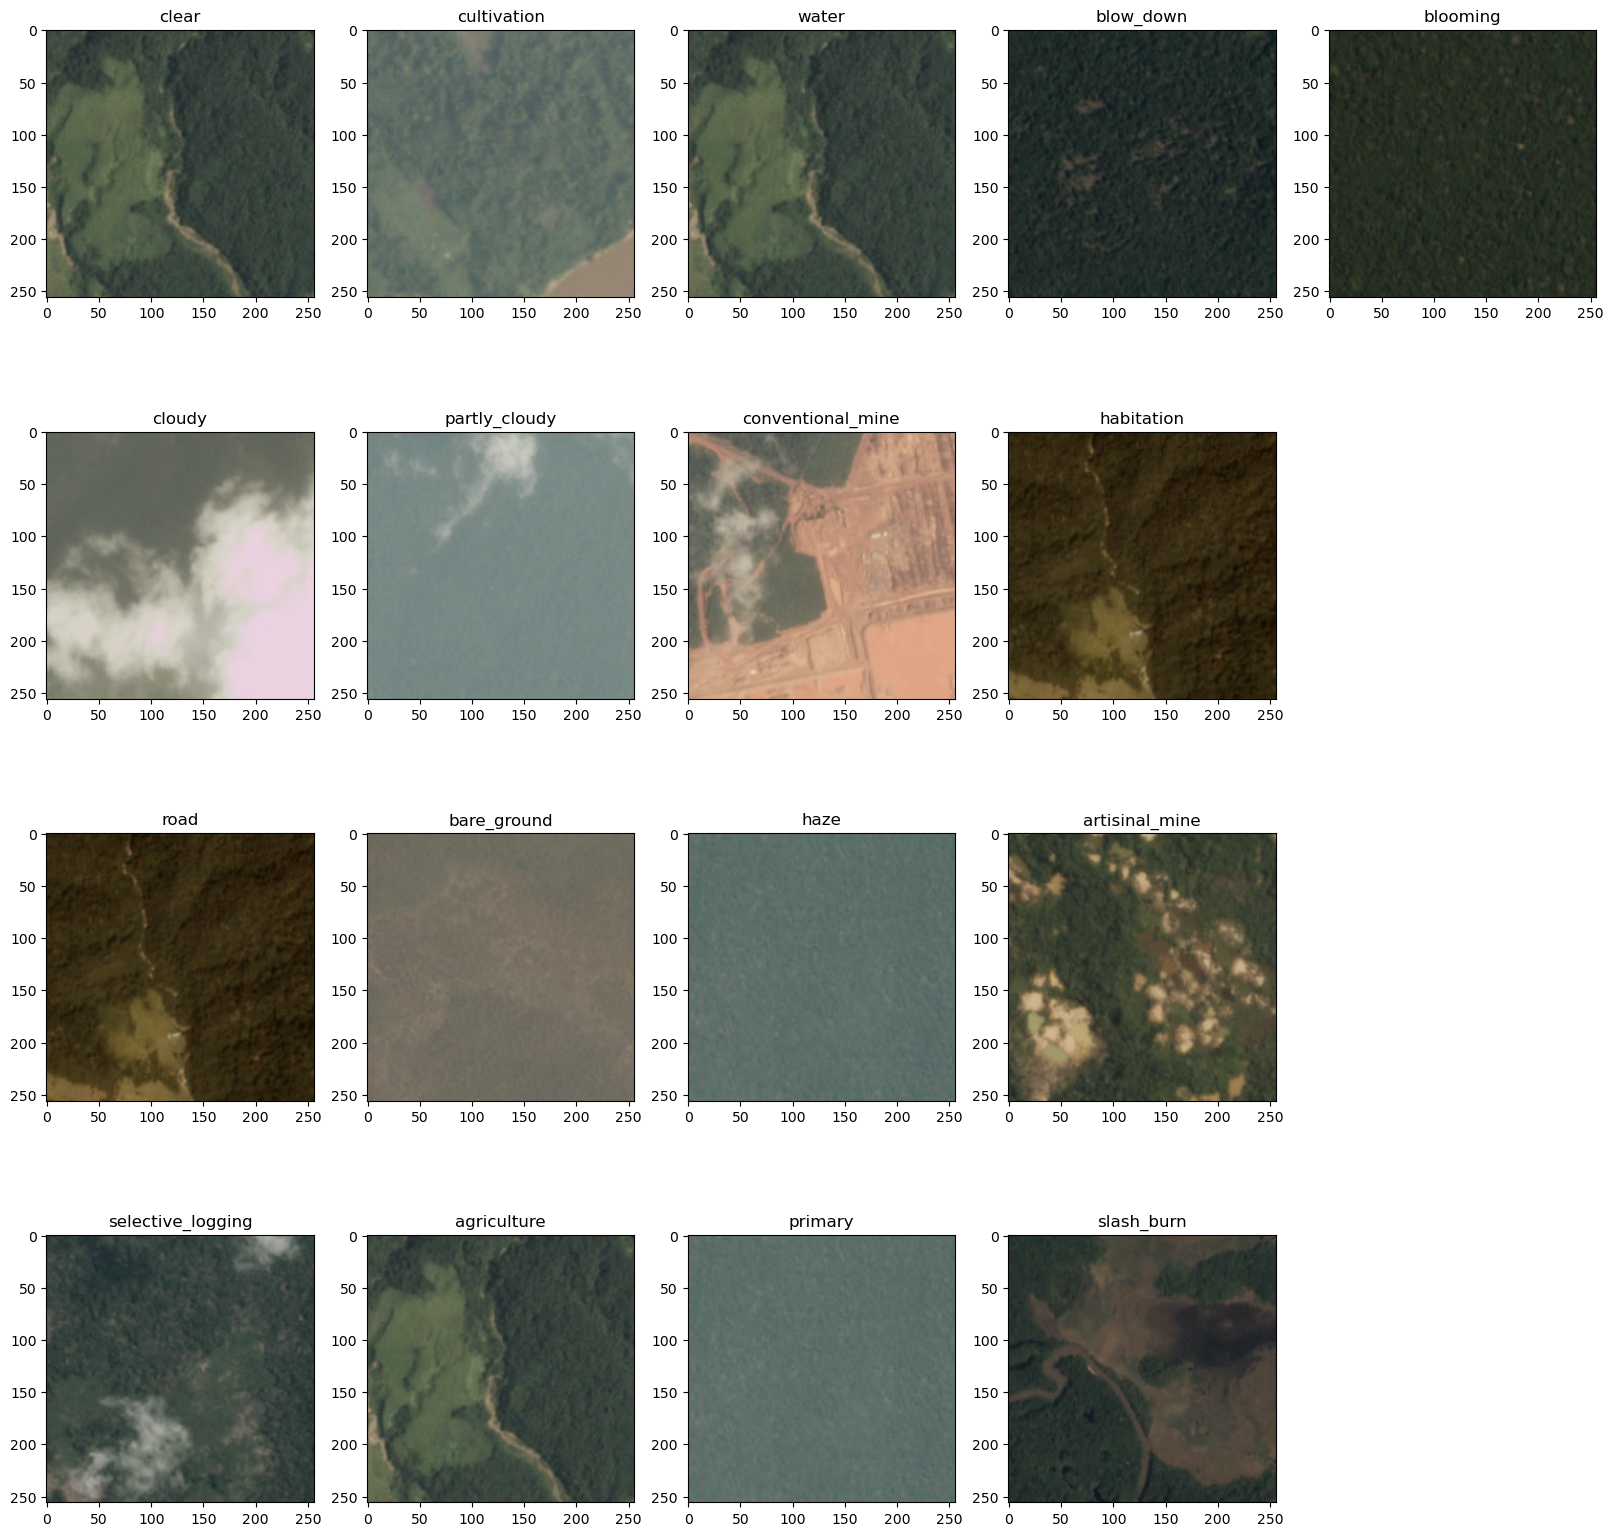

In [135]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = train_df.loc[train_df.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

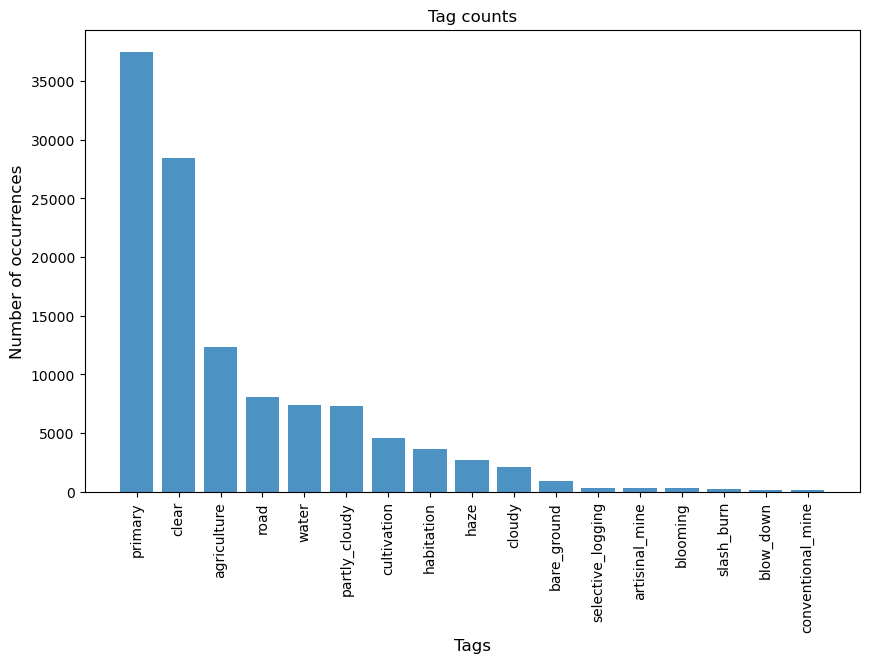

In [143]:
# Tags present in the dataset
tags = train_df['tags'].apply(lambda x: x.split(' '))
tags = [item for sublist in tags for item in sublist]
tag_counts = pd.Series(tags).value_counts()

# Plot the tags
plt.figure(figsize=(10,6))
plt.bar(tag_counts.index, tag_counts.values, alpha=0.8)
plt.title('Tag counts')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [144]:
labels = set()
def splitting_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# Create a copy of `train_df`
train_def = train_df.copy()
train_def['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)

['clear', 'cloudy', 'road', 'selective_logging', 'cultivation', 'partly_cloudy', 'bare_ground', 'agriculture', 'water', 'conventional_mine', 'haze', 'primary', 'blow_down', 'habitation', 'artisinal_mine', 'slash_burn', 'blooming']


In [146]:
for tag in labels:
    train_def[tag] = train_def['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train_def['image_name'] = train_def['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_def.head()

,image_name,tags,list_tags,clear,cloudy,road,selective_logging,cultivation,partly_cloudy,bare_ground,agriculture,water,conventional_mine,haze,primary,blow_down,habitation,artisinal_mine,slash_burn,blooming
0,train_0.jpg,haze primary,"[haze, primary]",0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,"[agriculture, clear, primary, water]",1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
2,train_2.jpg,clear primary,"[clear, primary]",1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,train_3.jpg,clear primary,"[clear, primary]",1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]",1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0


In [148]:
columns = list(train_def.columns[2:])


In [170]:
tar=list(train_def.image_name)


Preprocessing

In [173]:
from keras.preprocessing.image import ImageDataGenerator

In [175]:
# Initializing imagedatagenerator with a validation split of 0.2
weather = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
weather_generator = weather.flow_from_dataframe(dataframe=train_def,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = weather.flow_from_dataframe(dataframe=train_def,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 0 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning:

Found 40479 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.



Found 0 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning:

Found 40479 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.



In [186]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [207]:
import tensorflow as tf
# Define the model
def cnn_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

   # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [208]:
#initialize the model
model = cnn_model()

# Preview the model architecture
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 128)     

In [212]:
from keras.callbacks import EarlyStopping 

In [213]:
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [214]:
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

NameError: name 'train_generator' is not defined